In [ ]:
!pip3 install -U transformers datasets accelerate bitsandbytes peft freetype-py -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.1 MB/s eta 0:00:00


In [ ]:
import os
import csv
import random
import string
import nltk
from nltk.corpus import words
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def seedEverything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seedEverything()

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Download the NLTK word corpus
nltk.download("words")

# Set up directories
output_dir = "./data/dataset"
image_dir = os.path.join(output_dir, "images")
metadata_file = os.path.join(output_dir, "metadata.csv")

os.makedirs(image_dir, exist_ok=True)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
# Function to generate Random Words from NLTK
def generate_words(num_words=5, word_length_range=(5, 15)):
    word_list = [word for word in words.words() if word_length_range[0] <= len(word) <= word_length_range[1]]
    return random.sample(word_list, num_words)

In [ ]:
generate_words(num_words = 5)

['semisixth', 'Carniolan', 'amniomancy', 'treasonless', 'gelation']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import freetype
from PIL import Image, ImageFilter
import numpy as np
import uuid
import os


def load_font(font_path, char_size=36 * 64, pixel_height=96):
    face = freetype.Face(font_path)
    face.set_char_size(char_size)  # Set the font size in 1/64th points
    face.set_pixel_sizes(0, pixel_height)  # Set pixel sizes, specifying height
    return face


def draw_glyph(ax, face, char, position):
    face.load_char(char, freetype.FT_LOAD_RENDER | freetype.FT_LOAD_TARGET_NORMAL)
    bitmap = face.glyph.bitmap
    top = face.glyph.bitmap_top
    left = face.glyph.bitmap_left

    x = position[0] + left
    y = 200 - (position[1] - top)

    buffer_array = np.array(bitmap.buffer, dtype=np.uint8)
    if bitmap.width > 0 and bitmap.rows > 0:
        buffer_reshaped = buffer_array.reshape(bitmap.rows, bitmap.width)
        buffer_inverted = 255 - buffer_reshaped
        ax.imshow(
            buffer_inverted,
            cmap="gray",
            interpolation="bilinear",
            extent=(x, x + bitmap.width, y - bitmap.rows, y),
        )

    center_x = x + bitmap.width / 2
    center_y = y - bitmap.rows / 2
    return position[0] + face.glyph.advance.x // 64, position[1], center_x, center_y


def draw_ellipse_on_char(ax, centers, index, thickness, radius_x, radius_y):
    if 0 <= index < len(centers):
        center_x, center_y = centers[index]
        ellipse = patches.Ellipse(
            (center_x, center_y),
            width=2 * radius_x,  # Width of the ellipse (total width across the x-axis)
            height=2
            * radius_y,  # Height of the ellipse (total height across the y-axis)
            fill=False,
            edgecolor="red",
            linewidth=thickness,
        )
        ax.add_patch(ellipse)


def create_text_image(
    text,
    font_path,
    circle_index,
    thickness,
    scale_factor=1.0,  # Default scale factor is 1.0 (no scaling)
    padding=50,
    x_offset=0,
    y_offset=0,
    canvas_width=10,  # in inches
    canvas_height=2,  # in inches
    final_width=256,  # in pixels
    final_height=256,  # in pixels
    output_folder="output",
):
    try:
        face = load_font(font_path)
        total_width = 0
        max_height = 0
        glyph_sizes = []
        for char in text:
            face.load_char(
                char, freetype.FT_LOAD_RENDER | freetype.FT_LOAD_TARGET_NORMAL
            )
            glyph_width = face.glyph.advance.x // 64
            glyph_height = (
                face.glyph.bitmap_top + face.glyph.bitmap.rows - face.glyph.bitmap_top
            )
            glyph_sizes.append((glyph_width, glyph_height))
            total_width += glyph_width
            if glyph_height > max_height:
                max_height = glyph_height

        fig, ax = plt.subplots(figsize=(canvas_width, canvas_height), dpi=1200)
        ax.set_frame_on(False)
        ax.tick_params(axis="both", which="both", length=0)
        ax.set_xlim(0, total_width + 2 * padding)
        ax.set_ylim(0, 200)

        vertical_center = 100 + (max_height // 2)
        x, y = (padding, vertical_center)
        centers = []
        for i, (char, (glyph_width, glyph_height)) in enumerate(zip(text, glyph_sizes)):
            x, y, center_x, center_y = draw_glyph(ax, face, char, (x, y))
            centers.append((center_x, center_y))
            if i == circle_index:
                radius_x = (glyph_width / 2) * scale_factor
                radius_y = (glyph_height / 2) * scale_factor
                draw_ellipse_on_char(ax, centers, i, thickness, radius_x, radius_y)

        ax.set_xticks([])
        ax.set_yticks([])

        # Generate a unique high-resolution filename
        high_res_image_path = f"./tmp/ultra_high_res_text_{uuid.uuid4()}.png"
        fig.savefig(high_res_image_path, dpi=1200, bbox_inches="tight", pad_inches=0)

        # # close the figure
        plt.close(fig)

        # Open the high-resolution image, apply blur
        image = Image.open(high_res_image_path)
        blurred_image = image.copy()

        # Calculate the scaling factor while maintaining the aspect ratio
        original_width, original_height = blurred_image.size
        aspect_ratio = original_width / original_height
        if final_width / final_height > aspect_ratio:
            new_height = final_height
            new_width = int(new_height * aspect_ratio)
        else:
            new_width = final_width
            new_height = int(new_width / aspect_ratio)

        resized_image = blurred_image.resize((new_width, new_height))

        # Create a new image with white background
        final_image = Image.new("RGB", (final_width, final_height), "white")
        paste_x = (final_width - new_width) // 2 + x_offset
        paste_y = (final_height - new_height) // 2 + y_offset
        final_image.paste(resized_image, (paste_x, paste_y))

        # Generate a unique filename for the final image
        unique_id = uuid.uuid4()
        final_image_path = os.path.join(output_folder, f"text_image_{unique_id}.png")
        final_image.save(final_image_path)

        # Clean up the high-resolution image
        os.remove(high_res_image_path)

        return final_image_path
    except Exception as e:
        print(f"Error creating text image: {e}")
        return None

In [ ]:
import json
from joblib import Parallel, delayed

In [ ]:
os.makedirs("./tmp", exist_ok=True)


def get_all_fonts(parent_folder="fonts", exclude_bold=True, exclude_italic=True):
    import os

    font_files = []
    for root, dirs, files in os.walk(parent_folder):
        for file in files:
            if file.endswith(".ttf") or file.endswith(".otf"):
                font_files.append(os.path.join(root, file))

    if exclude_bold:
        font_files = [f for f in font_files if "bold" not in f.lower()]

    if exclude_italic:
        font_files = [f for f in font_files if "italic" not in f.lower()]

    print(f"Found {len(font_files)} fonts")

    return font_files

def generate_dataset(word, fonts, output_folder, scale_factor=0.6):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    configurations = []

    # Function wrapper to execute in parallel
    def process_task(config):
        image_path = create_text_image(
            text=config["word"],
            font_path=config["font_path"],
            circle_index=config["circle_index"],
            thickness=config["thickness"],
            scale_factor=config["scale_factor"],
            padding=config["padding"],  # Use variable padding
            x_offset=config["x_offset"],
            y_offset=config["y_offset"],
            canvas_width=config["canvas_width"],
            canvas_height=config["canvas_height"],
            final_width=config["final_width"],
            final_height=config["final_height"],
            output_folder=output_folder,
        )
        if image_path:
            config["image_path"] = image_path
            return config
        return None

    # Create task configurations
    tasks = []
    for font_path in fonts:
        for circle_index in range(0, len(word)):
            for thickness in range(4, 7, 1):
                for x_offset in range(0, 1, 1):
                    for y_offset in range(0, 1, 1):
                        for padding in [25, 50, 100, 200]:
                            config = {
                                "word": word,
                                "font_path": font_path,
                                "circle_index": circle_index,
                                "thickness": thickness,
                                "scale_factor": scale_factor,
                                "padding": padding,
                                "x_offset": x_offset,
                                "y_offset": y_offset,
                                "canvas_width": 10,
                                "canvas_height": 2,
                                "final_width": 512,
                                "final_height": 512,
                            }
                            tasks.append(config)

    # Use joblib to parallelize the task execution
    results = Parallel(n_jobs=-1)(delayed(process_task)(task) for task in tasks)

    # Collect valid configurations
    configurations = [result for result in results if result is not None]

    # Save the configurations to a JSON file
    with open(os.path.join(output_folder, "configurations.json"), "w") as f:
        json.dump(configurations, f, indent=4)

In [ ]:
fonts = get_all_fonts(parent_folder="fonts")
words = generate_words()

for word in words:
    output_folder = f"{image_dir}/{word}"
    generate_dataset(word, fonts, output_folder, scale_factor=1.4)

Found 5 fonts


In [ ]:
# Dataset Metadata
def save_metadata(metadata, metadata_path):
    with open(metadata_path, mode="w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["word", "circled_letter", "circled_index", "image_path"])
        writer.writeheader()
        writer.writerows(metadata)

In [ ]:
from glob import glob
from tqdm.notebook import tqdm


# Get all dataset Configuration Files
data_config_files = glob("data/dataset/images/*/configurations.json")
print(f"Found {len(data_config_files)} dataset configuration files.")

metadata = []
num_samples = 0

for file in tqdm(data_config_files):
    with open(file, "r") as f:
        data = json.load(f)
    for d in data:
      word = d['word']
      image_path = d['image_path']
      circled_index = d['circle_index']
      circled_letter = word[int(d['circle_index'])]
      metadata.append({
        "word": word,
        "circled_letter": circled_letter,
        "circled_index": circled_index,
        "image_path": image_path,
      })
      num_samples += 1

random.shuffle(metadata)
save_metadata(metadata, metadata_file)
print(f"Dataset created with {num_samples} samples.")

Found 5 dataset configuration files.


  0%|          | 0/5 [00:00<?, ?it/s]

Dataset created with 2820 samples.


In [ ]:
def show_examples(num_examples=5):
    metadata = pd.read_csv("./data/dataset/metadata.csv")
    i = 0
    plt.figure(figsize=(20, 10))
    for img_path in metadata["image_path"][:num_examples]:
        image = Image.open(img_path)
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"{i+1}")
        i += 1
    plt.show()

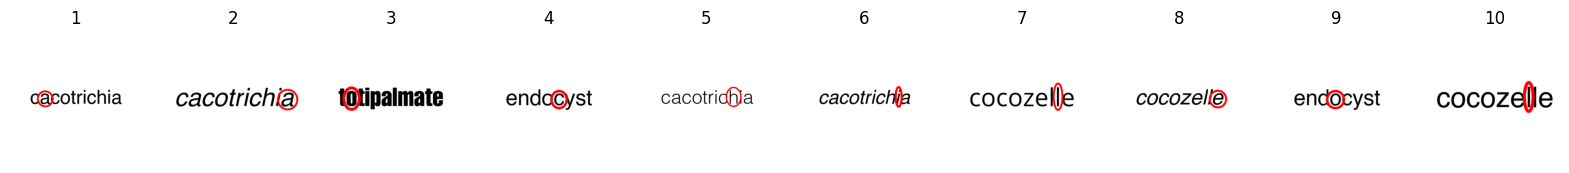

In [ ]:
# Show examples
show_examples(num_examples=10)

# Finetuning Paligemma 2

In [ ]:
from datasets import Dataset
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration, DefaultDataCollator
from transformers import TrainingArguments, Trainer
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

In [ ]:
# Load metadata
metadata_path = "./data/dataset/metadata.csv"
metadata = pd.read_csv(metadata_path)

# Prepare dataset with image paths
data = [
    {
        "image_path": row["image_path"],
        "text": row["word"],
        "label": row["circled_letter"],
    }
    for i, row in metadata.iterrows()
]

In [ ]:
hf_dataset = Dataset.from_list(data)

# Split into train and validation sets
split_data = hf_dataset.train_test_split(test_size=0.2, seed=42)

In [ ]:
split_data.keys()

dict_keys(['train', 'test'])

In [ ]:
len(split_data['train']), len(split_data['test'])

(2256, 564)

In [ ]:
samples = next(iter(split_data['train']))
samples

{'image_path': './data/dataset/images/cacotrichia/text_image_88ce84aa-63ea-4f6c-91e8-b2f50d5af168.png',
 'text': 'cacotrichia',
 'label': 'o'}

In [ ]:
samples = next(iter(split_data['test']))
samples

{'image_path': './data/dataset/images/facilely/text_image_05b9530e-2d66-4787-a64a-9fc99b4163f1.png',
 'text': 'facilely',
 'label': 'f'}

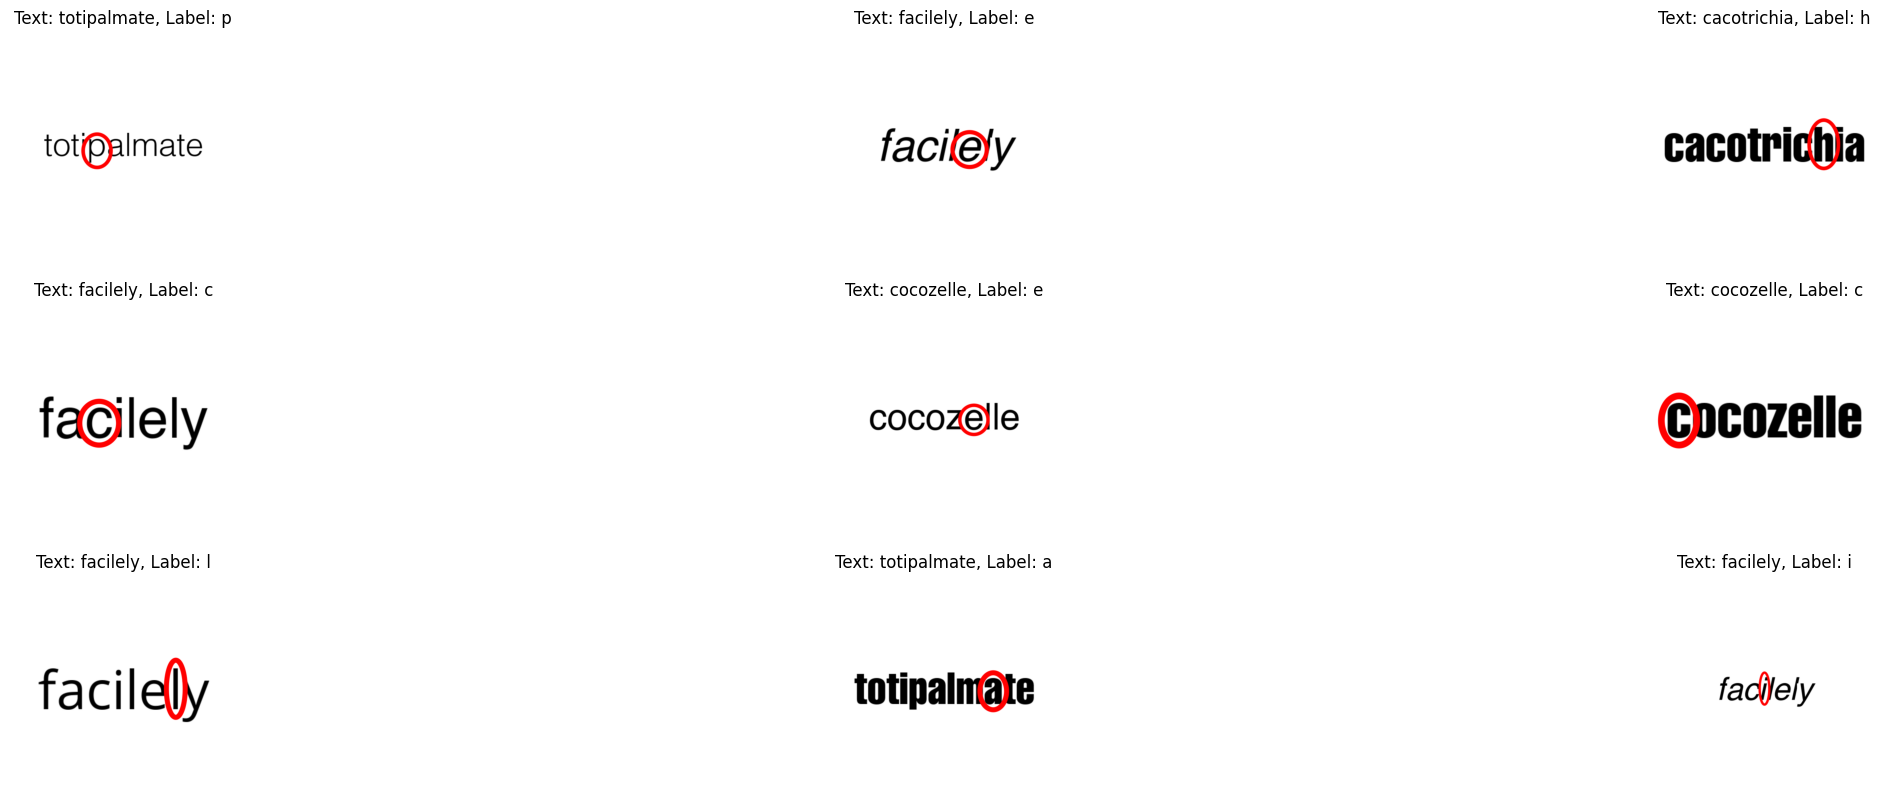

In [ ]:
# Test Dataset
training_data = split_data['train']
figure = plt.figure(figsize=(30, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(len(split_data['train']), size=(1,)).item()
    sample = training_data[sample_idx]
    img_path, text, label = sample.get("image_path"), sample.get("text"), sample.get("label")
    img = Image.open(img_path).convert("RGB")
    title_text = f"Text: {text}, Label: {label}"
    figure.add_subplot(rows, cols, i)
    plt.title(title_text)
    plt.axis("off")
    plt.imshow(img)
plt.show()

# Model

In [ ]:
# Bits and Bytes Config
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16)

# LoRA Config
lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

In [ ]:
# Model ID
model_id = "google/paligemma2-3b-pt-224"

In [ ]:
# Model and Processor
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/75.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.07G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

trainable params: 11,876,352 || all params: 3,044,118,768 || trainable%: 0.3901


In [ ]:
# Dataset Processor
processor = PaliGemmaProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:
DTYPE = model.dtype
DTYPE

torch.bfloat16

In [ ]:
def collate_fn(batch):
    images = [Image.open(sample["image_path"]).convert("RGB") for sample in batch]
    texts = ["<image>" + sample["text"] for sample in batch]
    labels = [sample["label"] for sample in batch]

    # Process text+images once
    model_inputs = processor(
        text=texts,
        images=images,
        suffix=labels,
        padding="longest",
        return_tensors="pt",
    )

    model_inputs = model_inputs.to(DTYPE).to(device)

    return model_inputs

In [ ]:
# # Training arguments
# training_args = TrainingArguments(
#     gradient_accumulation_steps=4,
#     optim="paged_adamw_8bit",
#     output_dir="paligemma2_finetuning",
#     eval_strategy="epoch",
#     per_device_train_batch_size=2,
#     per_device_eval_batch_size=2,
#     learning_rate=1e-3,
#     num_train_epochs=5,
#     weight_decay=1e-6,
#     adam_beta2=0.999,
#     save_steps=500,
#     logging_dir="./logs",
#     logging_steps=10,
#     remove_unused_columns=False,
#     bf16=True,
#     dataloader_pin_memory=False
# )


training_args = TrainingArguments(
    num_train_epochs=3,
    remove_unused_columns=False,
    per_device_train_batch_size=3,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=5e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=200,
    optim="paged_adamw_8bit",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="paligemma2_vlms_are_blind",
    bf16=True,
    dataloader_pin_memory=False
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_data["train"],
    eval_dataset=split_data["test"],
    data_collator=collate_fn,
)

# Fine-tune the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


TrainOutput(global_step=141, training_loss=0.7322295709704676, metrics={'train_runtime': 1152.792, 'train_samples_per_second': 5.871, 'train_steps_per_second': 0.122, 'total_flos': 2.61629864622216e+16, 'train_loss': 0.7322295709704676, 'epoch': 3.0})

In [ ]:
# Save fine-tuned model and processor
model.save_pretrained("./fine_tuned_paligemma")
processor.save_pretrained("./fine_tuned_paligemma")

[]

In [ ]:
from transformers.image_utils import load_image

# Test example
image_path = "data/dataset/images/disguisedly/text_image_55b22ace-af4f-4267-b647-6178c70cd034.png"
test_text = "disguisedly"

image = load_image(image_path)
inputs = processor(text=test_text, images=image, return_tensors="pt").to(model.device)

# Generate prediction
with torch.inference_mode():
    outputs = model.generate(**inputs)
decoded = processor.decode(outputs[0], skip_special_tokens=True)
print(decoded)


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


disguisedly
l em l


Input Text: <image>disguisedly
Predicted Output: disguisedly
d
--------------------------------------------------
Input Text: <image>disguisedly
Predicted Output: disguisedly
d
--------------------------------------------------
Input Text: <image>disguisedly
Predicted Output: disguisedly
g
--------------------------------------------------
Input Text: <image>disguisedly
Predicted Output: disguisedly
y
--------------------------------------------------
Input Text: <image>disguisedly
Predicted Output: disguisedly
s
--------------------------------------------------


IndexError: list index out of range

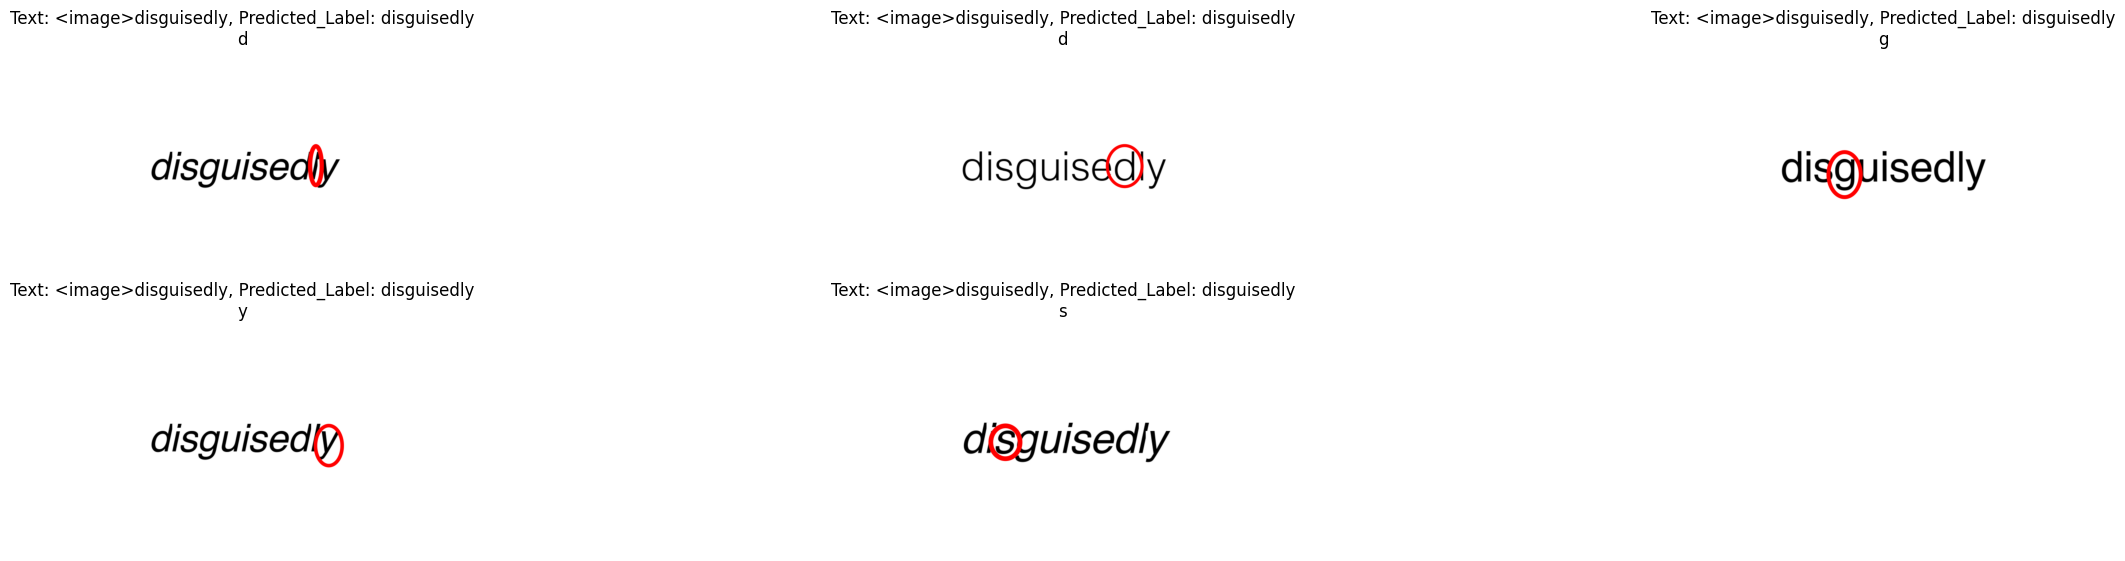

In [ ]:
from transformers.image_utils import load_image

# Test example: Paths to at least 5 images and corresponding text inputs
all_images = glob("data/dataset/images/disguisedly/*.png")
random.shuffle(all_images)
image_paths = all_images[:5]
test_texts = [
    "<image>disguisedly",
    "<image>disguisedly",
    "<image>disguisedly",
    "<image>disguisedly",
    "<image>disguisedly",
]

# Load images
images = [load_image(image_path) for image_path in image_paths]

# Process inputs in a batch
inputs = processor(text=test_texts, images=images, return_tensors="pt", padding=True).to(model.device)

# Generate predictions
with torch.inference_mode():
    outputs = model.generate(**inputs, max_new_tokens=1)

# Decode predictions
decoded_predictions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

# Print results
for i, (text, pred) in enumerate(zip(test_texts, decoded_predictions)):
    print(f"Input Text: {text}")
    print(f"Predicted Output: {pred}")
    print("-" * 50)



# plot Images with Result
figure = plt.figure(figsize=(30, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img = images[i - 1]
    text = test_texts[i - 1]
    pred_label = decoded_predictions[i - 1]
    title_text = f"Text: {text}, Predicted_Label: {pred_label}"
    figure.add_subplot(rows, cols, i)
    plt.title(title_text)
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [ ]:
!zip -r paligemma2_vlms_are_blind.zip paligemma2_vlms_are_blind/

  adding: paligemma2_vlms_are_blind/ (stored 0%)
  adding: paligemma2_vlms_are_blind/runs/ (stored 0%)
  adding: paligemma2_vlms_are_blind/runs/Dec15_03-03-43_52c468bd2ee0/ (stored 0%)
  adding: paligemma2_vlms_are_blind/runs/Dec15_03-03-43_52c468bd2ee0/events.out.tfevents.1734231836.52c468bd2ee0.1676.0 (deflated 62%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/ (stored 0%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/scheduler.pt (deflated 56%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/rng_state.pth (deflated 25%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/optimizer.pt (deflated 10%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/README.md (deflated 66%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/adapter_model.safetensors (deflated 8%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/adapter_config.json (deflated 56%)
  adding: paligemma2_vlms_are_blind/checkpoint-141/training_args.bin (deflated 51%)
  adding: paligemma2_vlms_are_blind/check